# Food project


![image.jpg](img.jpg)

Img source: fair-point.com

## Discovery (identificazione del problema e degli obiettivi)

Negli ultimi secoli la popolazione mondiale è aumentata notevolmente e secondo l'ONU (fonte del 2019), nel 2050 potrebbe arrivare a quota *10 miliardi*. 

In maniera direttamente proporzionale **sono aumentate anche le domande di cibo, energia ed acqua**, per soddisfare tale bisogno. 

Sfortunamente, i costanti monitoraggi sul cambiamento climatico indicano che la **temperatura massima annuale sulla Terra sta cambiando pericolosamente** e parte di questo effetto è *direttamente correlato alla produzione agricola e all'allevamento* (questo settore ha un impatto del **25-30% sulle emissioni totali di CO₂**):


**L'obiettivo di questo notebook** è quello di fornire una visione di insieme sulla *produzione mondiale di alimenti e mangimi* e sui *principali fenomeni inquinanti* (emissioni di CO₂ dovute alla catena produttiva e variazioni di temperatura).

### Spunti e domande che guideranno questa analisi

#### Confronto tra produzione di cibo e mangime a livello mondiale: 
    
- Come è variata la loro produzione negli anni?

- Quali paesi sono i maggiori produttori? 

- Quali sono gli alimenti maggiormente prodotti?

#### Processo produttivo e inquinamento:

- La produzione di quali alimenti ha un impatto maggiormente negativo sull'ambiente?

- Quale fase della produzione alimentare contribuisce maggiormente all'emissione di gas serra?

- Quali sono gli alimenti la cui produzione ha meno impatto per le emissioni di gas serra?

- Quanto si è innalzata la temperatura globale dall'ultimo secolo ad oggi?

---
---
## Data selection

Questo progetto sfrutta diversi datasets: 

- Il [primo](https://www.kaggle.com/datasets/dorbicycle/world-foodfeed-production), disponibile sul **portale FAOSTAT** della FAO (Food and Agriculture Organization of the United Nations), contiene i dati di produzione di cibi (denominati 'food') e mangimi (denominati 'feed') di ogni paese del mondo, dal 1961 al 2013.

- Il [secondo](https://www.kaggle.com/datasets/selfvivek/environment-impact-of-food-production), fornito da **Our World in Data**, mostra principalmente i quantitativi di gas serra che sono emessi durante gli step della catena produttiva per la realizzazione dei 43 alimenti più comuni prodotti nel mondo.

- Il [terzo](https://www.kaggle.com/datasets/sevgisarac/temperature-change/code?datasetId=1056827&sortBy=voteCount), fornito anch'esso da **FAOSTAT** coniente statistiche sulla variazione media della temperatura superficiale per paese, con aggiornamenti annuali del periodo 1961–2019. Questi valori sono intesi come anomalie, cioè variazioni di temperatura rispetto a una climatologia di base, corrispondente al periodo 1951-1980.

### Import di moduli e dati

In [32]:
# Librerie essenziali
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerie utili
import fuzzywuzzy
from fuzzywuzzy import process

# Settings delle librerie
pd.set_option('display.max_columns', None) # Preferisco visualizzare sempre tutte le colonne a disposizione dei datasets
pd.set_option('display.max_rows', 66)

In [33]:
# Dataset della produzione di cibi/mangimi dei vari paesi del mondo
fao_df = pd.read_csv('Data/Fao.csv')
df_prod = fao_df.copy()

# Dataset delle emissioni di gas serra e dei consumi di acqua per la produzione di alimenti
emission_df = pd.read_csv('Data/Food_Production.csv')
df_emiss = emission_df.copy()

# Dataset delle variazioni di temperatura 
temperature_df = pd.read_csv('./Data/Environment_Temperature_change_E_All_Data_NOFLAG.csv')
df_temp = temperature_df.copy()

# Dataset utile contenente i codici ISO-3
country_code = pd.read_csv('./Data/FAOSTAT_data_11-24-2020.csv')

---
---
## Data cleaning

### Dataset della produzione di cibi/mangimi dei vari paesi del mondo

In [34]:
print(f"Dimensioni del dataframe: {df_prod.shape[0]} righe e {df_prod.shape[1]} colonne.")
print("\nColonne del dataframe:\n", df_prod.columns)
df_prod.head()

Dimensioni del dataframe: 21477 righe e 63 colonne.

Colonne del dataframe:
 Index(['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item',
       'Element Code', 'Element', 'Unit', 'latitude', 'longitude', 'Y1961',
       'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968', 'Y1969',
       'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976', 'Y1977',
       'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984', 'Y1985',
       'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013'],
      dtype='object')


,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,1928.0,1904.0,1666.0,1950.0,2001.0,1808.0,2053.0,2045.0,2154.0,1819.0,1963.0,2215.0,2310.0,2335.0,2434.0,2512.0,2282.0,2454.0,2443.0,2129.0,2133.0,2068.0,1994.0,1851.0,1791.0,1683.0,2194.0,1801.0,1754.0,1640.0,1539.0,1582.0,1840.0,1855.0,1853.0,2177.0,2343.0,2407.0,2463.0,2600.0,2668.0,2776.0,3095.0,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,183.0,183.0,182.0,220.0,220.0,195.0,231.0,235.0,238.0,213.0,205.0,233.0,246.0,246.0,255.0,263.0,235.0,254.0,270.0,259.0,248.0,217.0,217.0,197.0,186.0,200.0,193.0,202.0,191.0,199.0,197.0,249.0,218.0,260.0,319.0,254.0,326.0,347.0,270.0,372.0,411.0,448.0,460.0,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,76.0,76.0,76.0,76.0,76.0,75.0,71.0,72.0,73.0,74.0,71.0,70.0,72.0,76.0,77.0,80.0,60.0,65.0,64.0,64.0,60.0,55.0,53.0,51.0,48.0,46.0,46.0,47.0,46.0,43.0,43.0,40.0,50.0,46.0,41.0,44.0,50.0,48.0,43.0,26.0,29.0,70.0,48.0,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,237.0,237.0,237.0,238.0,238.0,237.0,225.0,227.0,230.0,234.0,223.0,219.0,225.0,240.0,244.0,255.0,185.0,203.0,198.0,202.0,189.0,174.0,167.0,160.0,151.0,145.0,145.0,148.0,145.0,135.0,132.0,120.0,155.0,143.0,125.0,138.0,159.0,154.0,141.0,84.0,83.0,122.0,144.0,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,210.0,210.0,214.0,216.0,216.0,216.0,235.0,232.0,236.0,200.0,201.0,216.0,228.0,231.0,234.0,240.0,228.0,234.0,228.0,226.0,210.0,199.0,192.0,182.0,173.0,170.0,154.0,148.0,137.0,144.0,126.0,90.0,141.0,150.0,159.0,108.0,90.0,99.0,72.0,35.0,48.0,89.0,63.0,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [35]:
# Rimuovo la 'Y' dalle labels degli anni
df_prod.rename(columns={n:n[1:] for n in df_prod.columns if 'Y' in n}, inplace=True)

# Sostituisco gli spazi nelle features delle colonne per renderle più maneggiabili
df_prod.rename(columns={n:n.replace(' ', '_') for n in df_prod.columns if ' ' in n}, inplace= True)

#### Valori nulli e variabili quantitative

Procedo verificando la presenza di valori nulli (*NaN*) nel dataset. Se effettivamente presenti, approfondisco l'analisi per sapere quanti sono e in quali colonne sono maggiormente frequenti. Inoltre, proverò a fare un *imputation*, ovvero a stabilire il motivo della loro presenza. 

In [36]:
pd.set_option('display.max_rows', 63)

# La funzione pd.DataFrame.info() è un ottimo strumento, ma in questo si ottiene output un po' confusionario 
# quindi costruisco una tabella riassuntiva più leggibile sui Dtype, valori unici e valori nulli di tutte le colonne
print("Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:")

df_prod_info= pd.DataFrame({"Dtype": df_prod.dtypes, 
                            "Valori unici": df_prod.nunique(),
                            "Valori mancanti(%)": round(df_prod.isnull().sum()/df_prod.shape[0]*100, 2)
                            }).rename_axis('Colonne', axis='rows')                       

df_prod_info

Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:


,Dtype,Valori unici,Valori mancanti(%)
Colonne,,,
Area_Abbreviation,object,169,0.00
Area_Code,int64,174,0.00
Area,object,174,0.00
Item_Code,int64,117,0.00
Item,object,115,0.00
Element_Code,int64,2,0.00
Element,object,2,0.00
Unit,object,1,0.00
latitude,float64,173,0.00


Le colonne che contengono le percentuali maggiori di valori nulli sono quelle che indicano i dati di produzione *tra il 1961 e il 1991*. 

Come si può leggere tra la documentazione del dataset:

>The Food Balance sheet's data was relatively complete. A few countries that do not exist anymore, such as Czechoslovakia, were deleted from the database. Countries which were formed lately such as South Sudan were kept, even though they do not have all full data going back to 1961. [...]

Quindi, in un certo senso, sembrerebbe che particolari *evoluzioni geopolitiche di alcuni paesi* siano la causa dell'indisponibilità dei dati.  

Prendo un campione a caso dove sono presenti questi valori nulli, cercando di fare chiarezza e di confermare le informazioni contenute nella documentazione del dataset.  

In [37]:
# Ricerco il subset del dataframe contenente almeno un valore nullo nelle righe
df_null_rows = df_prod.loc[df_prod.isnull().any(axis=1)]
print(f'\nNumero di righe con valori nulli: {df_null_rows.shape[0]}')

# Imposto un random seed per rendere pseudorandomica e riproducibile questa cella
np.random.seed(0)

# Seleziono un campione a caso di 5 elementi
df_null_rows.sample(5)


Numero di righe con valori nulli: 3539


,Area_Abbreviation,Area_Code,Area,Item_Code,Item,Element_Code,Element,Unit,latitude,longitude,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
17328,SVK,199,Slovakia,2517,Millet and products,5521,Feed,1000 tonnes,48.67,19.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1,1
13020,MNE,273,Montenegro,2617,Apples and products,5142,Food,1000 tonnes,42.71,19.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,19.0,34.0,38.0,33.0,27.0,14,13
17526,SVN,198,Slovenia,2733,Pigmeat,5142,Food,1000 tonnes,46.15,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,81.0,84.0,75.0,70.0,73.0,77.0,87.0,76.0,82.0,78.0,88.0,88.0,88.0,89.0,84.0,84.0,80.0,81.0,76.0,69,58
11128,LVA,119,Latvia,2656,Beer,5142,Food,1000 tonnes,56.88,24.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,53.0,66.0,67.0,66.0,73.0,82.0,100.0,99.0,105.0,134.0,142.0,124.0,144.0,147.0,158.0,156.0,146.0,164.0,172.0,163,156
16103,RUS,185,Russian Federation,2560,Coconuts - Incl Copra,5142,Food,1000 tonnes,61.52,105.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,2.0,2.0,10.0,10.0,21.0,28.0,42.0,45.0,47.0,52.0,45.0,59.0,42.0,39.0,48.0,63.0,57,63


In effetti, in questi 5 paesi selezionati a caso: 'Slovacchia', 'Montenegro', 'Slovenia', 'Lettonia' e 'Federazione Russa', i dati di produzione sono mancanti dal 1961 al 1991 (il Montenegro fino al 2005). 

Cercando informazioni sulla storia geopolitica di questi paesi si può leggere:

- *Slovacchia*: [...] La Repubblica Slovacca e la Repubblica Ceca sono nate il 1º gennaio 1993 dalla divisione, sancita dal parlamento della Cecoslovacchia, che **già dal 1990 aveva assunto il nome di Repubblica Federale Ceca e Slovacca**;

- *Montenegro*: [...] Fino al 2 giugno 2006 la Repubblica del Montenegro è stata unita alla Repubblica di Serbia con il nome di Serbia e Montenegro. **Dal 3 giugno 2006 il Montenegro è diventato uno Stato indipendente**;

- *Slovenia*: [...] Dal 1º maggio 2004 la Slovenia è membro dell'Unione europea e la valuta nazionale, dal 1º gennaio 2007, è l'euro, che ha sostituito il tallero sloveno, adottato **nel 1991 dopo l'indipendenza** [...];

- *Lettonia*: [...] L'URSS riconobbe **la Lettonia come Stato indipendente il 6 settembre 1991** [...];

- *Federazione Russa*: [...] Nell'agosto del 1991 il tentato colpo di Stato militare per deporre Gorbačëv e preservare l'Unione Sovietica portò invece alla fine del Partito Comunista dell'Unione Sovietica. Nonostante la contraria volontà espressa dal popolo, **il 26 dicembre 1991 l'Unione Sovietica si dissolse in quindici Stati post-sovietici**.

Fonte: [Wikipedia](https://it.wikipedia.org/wiki/Pagina_principale)

Questo risultato **è in linea con la documentazione** del dataset, giustificando il retroscena che riguarda la presenza di valori mancanti.

**È conveniente** eliminare dal dataframe le righe che contengono valori nulli, oppure si rischia di perdere un numero **eccessivo** di informazioni? Eseguo un test per controllare.

In [38]:
# Creo un dataframe per testare l'eliminazione delle righe che contengono valori nulli 
test_drop = df_prod.dropna()

# Calcolo la percentuale di dati eliminati rispetto dal dataframe originale
rows_removal_perc = round((1-test_drop.shape[0]/df_prod.shape[0])*100,2)

# Stampo le informazioni sul numero di righe totali e la shape dei due dataframes
print(f"\nRighe del dataframe originale: {df_prod.shape[0]}.") 

print(f"\nRighe del dataframe dopo aver rimosso i valori mancanti: {test_drop.shape[0]}")

print(f'\nLa rimozione delle righe che contengono valori NaN ha eliminato il {rows_removal_perc}% dei dati!')


Righe del dataframe originale: 21477.

Righe del dataframe dopo aver rimosso i valori mancanti: 17938

La rimozione delle righe che contengono valori NaN ha eliminato il 16.48% dei dati!


Secondo me, in questo caso **la perdita di dati è tollerabile**. Quindi, continuerò lo studio di questo dataset adottando questa procedura.

Avrei anche potuto sostituire i valori NaN con 0 tramite *fillna()* e poi eliminare le righe con solo zeri e valori negativi. Tuttavia, ho visto che la differenza nella procedura *in questo caso* è minima. 

Per terminare la pulizia delle variabili quantitative elimino tutte le righe dove i valori di produzione lungo l'intero periodo temporale sono **pari a zero o negativi**. 

In [39]:
# Seleziono un subset del dataframe contenente tutte le colonne degli anni di produzione del dataframe
years_df = test_drop.loc[:, '1961':]

# Ricavo gli indici delle righe che contengono anche solo un numero negativo e tutti 0 dal 1961 al 2013
idx_to_drop = years_df.loc[((years_df < 0).any(axis=1)) | (years_df == 0).all(axis=1)].index

# Elimino tutte le righe con questi indici
test_drop = test_drop.drop(idx_to_drop)

# Riporto il nome del dataframe a df_prod
df_prod = test_drop.copy().reset_index(drop=True)

# Trasformo i valori numerici in 'int64'
df_prod.loc[:, '1961':] = df_prod.loc[:, '1961':].astype('int64')

#### Cleaning variabili qualitative

##### Manipolazione della colonna 'Area'

Sistemo l'unica incongruenza

In [40]:
df_prod.Area.replace({"C�te d'Ivoire":"Côte d'Ivoire"}, inplace=True)

##### Esplorazione e manipolazione della colonna 'Item'

L'ideale sarebbe ottenere *congruenza tra i nomi degli alimenti* del primo e del secondo dataset.

Per non complicare eccessivamente la pulizia dei dati, mi preoccuperò solo di avere una coerenza tra i primi 20 alimenti più rilevanti, *in termini di emissioni totali*, del dataset delle emissioni ed i loro corrispettivi nel dataset della produzione.

Uno strumento utilissimo per controllare le incongruenze o le somiglianze tra diversi elementi è *fuzzywuzzy*.

In [41]:
# Scrivo una funzione che mi tornerà utile anche per altri controlli
def fuzz_finder(dictionary, test, target, treshold, first, last, show):

    """Questa funzione inserisce, in un dizionario a propria scelta e già stato inizializzato, 
    le migliori corrispondenze tra i nomi degli elementi di due liste 'test' e 'target'. 

    Le chiavi del dizionario corrisponderanno ai nomi degli elementi da testare, 
    mentre i valori corrisponderanno alla lista degli elementi ottenuti per miglior match. 
    Per testare gli elementi di una lista con sè stessa è sufficiente specificarla come 'test' e 'target'.
     
    Si può specificare con 'treshold' un numero tra 0 e 100, per stabilire un punteggio soglia da raggiungere 
    tra il primo e il secondo elemento, dove 100 indica una perfetta corrispondenza anche in termini di lettere maiuscole
    e minuscole.
    
    Con 'first' e 'last' si decide il primo e l'ultimo elemento da inserire nella lista dei valori nel dizionario. 
    Per saltare il confronto del primo elemento con sè stesso, impostare 'first' = 1.
    
    Con 'show' = True si può decidere se visualizzare o meno l'output della funzione. La formattazione dell'output è stata
    resa più gradevole che stampare il dizionario stesso."""

    # Counter per facilitare la lettura dell'output
    counter = 0

    for item in test:

        # Restituisce una lista di tuple contenenti nome e punteggio
        matches = fuzzywuzzy.process.extract(item, target, limit=None, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        
        if matches[1][1] >= treshold and first != last:        

            key = item 
            
            values = [matches[n][0] for n in range(first,last+1)]
            
            dictionary[key] = values
        
        elif matches[1][1] >= treshold and first == last:

            key = item

            value = matches[0][0]

            dictionary[key] = value


    if show:

        for key, values in dictionary.items():

            counter += 1
            print(f"{counter} Elemento in esame: {key}\n    Migliori matches: {values}\n")

In [42]:
# Devo prima ordinare il dataframe delle emissioni, in ordire decrescente, secondo la colonna 'Total_emissions'
emiss_sorted = df_emiss.sort_values('Total_emissions', ascending=False).head(20)

# Poi estraggo la lista dei 20 alimenti
top20_emission_sorted = emiss_sorted['Food product'].unique()

In [43]:
# Dizionario dove inserire le voci
dict_20_item = {}

# Lista da testare
test_list = top20_emission_sorted

# Lista con cui fare i confronti 
target_list = df_prod.Item.unique()

# Migliori match con i primi 5 elementi in ordine di punteggio. Per visualizzare l'outupt impostare 'show' = True
fuzz_finder(dictionary=dict_20_item, test=test_list, target=target_list, treshold=0, first=0, last=5, show=False)

In [44]:
# Il dizionario qui sotto è stato creato da quello costruito nella cella precedente. 
# Per ogni chiave ho eliminato tutti i valori tranne uno, quello maggiormente attinente col nome della chiave. 

# *Nota:* i nomi delle chiavi del dizionario corrispondo ai nomi degli elementi del dataset delle EMISSIONI, 
# mentre i nomi dei valori corrispondono a quelli del dataset della PRODUZIONE.

inconsistencies_dict = {  
  'Beef (beef herd)': 'Meat, Other', 
  'Beef (dairy herd)': 'Meat, Other', 
  'Cane Sugar': 'Sugar cane',
  'Cheese': 'NONE', 
  'Coffee': 'Coffee and products',   
  'Dark Chocolate': 'NONE', 
  'Eggs': 'Eggs', 
  'Fish (farmed)': 'Fish, Seafood',
  'Lamb & Mutton': 'Mutton & Goat Meat', 
  'Milk': 'Milk - Excluding Butter', 
  'Olive Oil': 'Olive Oil', 
  'Palm Oil': 'Palm Oil', 
  'Pig Meat': 'Pigmeat', 
  'Poultry Meat': 'Poultry Meat', 
  'Rapeseed Oil': 'Rape and Mustard Oil', 
  'Rice': 'NONE', 
  'Shrimps (farmed)': 'NONE', 
  'Soybean Oil': 'Soyabean Oil', 
  'Sunflower Oil': 'Sunflowerseed Oil',
  'Tofu': 'NONE' 
  }

Qui possiamo vedere gli elementi esattamente congruenti tra i due datasets.

In [45]:
exact_matches = {key:values for (key, values) in inconsistencies_dict.items() if key==values}
exact_matches

{'Eggs': 'Eggs',
 'Olive Oil': 'Olive Oil',
 'Palm Oil': 'Palm Oil',
 'Poultry Meat': 'Poultry Meat'}

Sistemo le 'incongruenze lievi', ovvero nomenclature quasi identiche tra gli elementi dei due datasets.

In [46]:
# Richiamo gli elementi con 'lieve incongruenza' in un dizionario
slight_inconsistencies = {key:value for (key, value) in inconsistencies_dict.items() 
                          if key != value and value != 'NONE' and value != 'Meat, Other'}

# Poiché voglio che le modifiche vengano fatte nel dataframe delle produzioni, prima di rimpiazzare 
# i nomi nel dataframe delle produzioni, devo invertire le nomenclature di chiavi e valori.
reversed_slight_inc = {key:value for (value, key) in slight_inconsistencies.items()}

# Sostituisco i nomi nel dataframe della produzione di cibo/mangimi
df_prod.Item.replace(reversed_slight_inc, inplace=True)

Sistemo le incongruenze tra elementi generalizzati: 'meat' e 'beef'. Devo capire se ci sono alcune voci tra gli elementi del dataset della produzione che si possono associare ad alimenti a base di carne bovina. 

In [47]:
# Creo dei filtri per entrambi i casi
find_meat = df_prod.Item.map(lambda text: 'meat' in text.lower())
find_beef = df_prod.Item.map(lambda text: 'beef' in text.lower())

# Ottengo la lista dei valori unici per entrambi
prod_meat_list = df_prod.loc[find_meat].Item.unique().tolist()
prod_beef_list = df_prod.loc[find_beef].Item.unique().tolist()


if prod_meat_list:

    print("\nElementi con la dicitura 'meat' nel dataframe della produzione ancora da sistemare:")

    for n in prod_meat_list:

        if not n in reversed_slight_inc.values() and n not in exact_matches.values():
            
            print(n)    
else:

    print("Non ci sono elementi con dicitura 'meat' da sistemare")


if prod_beef_list:

    print("\nElementi con la dicitura 'beef' nel dataframe della produzione ancora da sistemare:")

    for n in prod_beef_list:

        if n in reversed_slight_inc.values() and n not in exact_matches.values():
            
            print(n) 
          
else:

    print("\nNon ci sono elementi con dicitura 'beef' da sistemare")


Elementi con la dicitura 'meat' nel dataframe della produzione ancora da sistemare:
Bovine Meat
Meat, Other
Meat

Non ci sono elementi con dicitura 'beef' da sistemare


'Bovine Meat' si riferisce alla carne bovina derivata dagli allevamenti, come riportato nella [documentazione](https://www.fao.org/faostat/en/#data/FBSH) del dataset. Pertanto, *si può sostituire* questa voce con l'elemento 'Beef (beef herd)', che indica le carni bovine provenienti dalle mandrie;

La voce 'Meat, Other' *si può ignorare*, trattandosi di animali non bovini;

'Meat' non possiede una descrizione nella documentazione del dataset, pertanto *non è sostituibile*.

In [48]:
# Sostituisco il nome nel dataframe della produzione di cibo/mangimi
df_prod.Item.replace({'Bovine Meat': 'Beef (beef herd)'}, inplace=True)

Infine, provo a sistemare le incongruenze gravi, ovvero quelle voci che non hanno trovato alcuna corrispondenza con fuzzywuzzy.

In [49]:
# Incongruenze gravi: 
heavy_inconsistencies = {key: value for key, value in inconsistencies_dict.items() if value == 'NONE'}
heavy_inconsistencies

{'Cheese': 'NONE',
 'Dark Chocolate': 'NONE',
 'Rice': 'NONE',
 'Shrimps (farmed)': 'NONE',
 'Tofu': 'NONE'}

La documentazione nel dataset della FAO aiuta (in piccola parte) a risolvere queste ultime incongruenze: 

- 'Rice' è presente nel dataframe della produzione con dicitura 'Rice (Milled Equivalent)' quindi *può essere sostituito*;

- 'Cheese', 'Dark Chocolate', 'Shrimps (farmed)' e 'Tofu' sono tutte voci riferite ad un alimento specifico che non posso scorporare dal dataset della produzione (es.: 'Tofu' è rappresentato dalla voce 'Soyabeans', ma oltre a questo la voce 'Soyabeans' include anche salsa di soia, pasta di soia e semi di soia). Pertanto queste voci *non possono essere sostituite*.

In [50]:
# Sostituisco il nome nel dataframe della produzione di cibo/mangimi
df_prod.Item.replace({'Rice (Milled Equivalent)': 'Rice'}, inplace=True)

# Resetto l'indice
df_prod.reset_index(drop=True, inplace=True)

### Dataset delle emissioni di gas serra e dei consumi di acqua

In [51]:
print(f"Dimensioni del dataframe: {df_emiss.shape[0]} righe e {df_emiss.shape[1]} colonne.")
print("\nColonne del dataframe:\n", df_emiss.columns)
df_emiss.head()

Dimensioni del dataframe: 43 righe e 23 colonne.

Colonne del dataframe:
 Index(['Food product', 'Land use change', 'Animal Feed', 'Farm', 'Processing',
       'Transport', 'Packging', 'Retail', 'Total_emissions',
       'Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)',
       'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
       'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)',
       'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater withdrawals per 100g protein (liters per 100g protein)',
       'Freshwater withdrawals per kilogram (liters per kilogram)',
       'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)',
       'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)',
       'Land use per 1000kcal (m² per 1000kcal)',
       'Land use per kilogram (m² per kilogram)',
       'Land use per 100g protein (m² per 100g protein)',
       'Scarcity-weighted water use per kilogram (li

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),Eutrophying emissions per kilogram (gPO₄eq per kilogram),Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein),Freshwater withdrawals per 1000kcal (liters per 1000kcal),Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,11.23,8.638462,183.911552,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,35.07,49.394366,609.983722,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


In [52]:
# Rimuovo gli spazi nei titoli delle colonne che non contengono parentesi
df_emiss.rename(columns={cols: cols.replace(' ', '_') for cols in df_emiss.columns if not '(' in cols}, inplace=True)

# Modifico i titoli più lunghi e li sostituisco nel dataframe, eliminando anche gli spazi
replace_dict = {
    "Eutrophying emissions per kilogram (gPO₄eq per kilogram)":"Eutrophying emissions(gPO₄/kg)",
    "Freshwater withdrawals per kilogram (liters per kilogram)":"Freshwater withdrawals(L/kg)",
    "Land use per kilogram (m² per kilogram)":"Land use(m²/kg)"
    }

df_emiss.rename(columns={key:value.replace(' ', '_') for (key, value) in replace_dict.items()}, inplace=True)

#### Valori nulli

Anche per questo dataset, vado a vedere per primi i valori nulli.

In [53]:
pd.set_option('display.max_rows', 23)


print("Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:")

emission_df_info = pd.DataFrame({"Dtype": df_emiss.dtypes, 
                                 "Valori unici": df_emiss.nunique(),
                                 "Valori mancanti(%)": round(df_emiss.isnull().sum()/df_emiss.shape[0]*100, 2)
                                 }).rename_axis('Colonne', axis='rows')                       

emission_df_info.sort_values(by='Valori mancanti(%)')

Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:


,Dtype,Valori unici,Valori mancanti(%)
Colonne,,,
Food_product,object,43,0.00
Land_use_change,float64,21,0.00
Animal_Feed,float64,10,0.00
Farm,float64,24,0.00
Processing,float64,10,0.00
Transport,float64,8,0.00
Packging,float64,10,0.00
Retail,float64,4,0.00
Total_emissions,float64,33,0.00


I valori nulli si concentrano in alcune colonne che valutano:

- L'emissione di molecole eutrofizzanti (PO₄);

- La quantità di acqua necessaria per la produzione dell'alimento; 

- L'emissione di anidride carbonica (CO₂);

- L'area di terreno utilizzato (m²);

- Il rapporto tra l'acqua necessaria per la produzione dell'alimento e la disponibilità locale di acqua. 

Per ognuna di queste 5 colonne (tranne quella relativa alla CO₂) si è indicato il valore di emissione/consumo in rapporto a 1 kilogrammo, 100 grammi di proteine, o 1000 kcal di alimento prodotto. 

Per questa analisi intendo tralasciare i dati delle emissioni rapportate alle proteine e alle kcal, concentrandomi su quelle espresse *per kilogrammo di prodotto*.

In [54]:
# Lista delle colonne con valori nulli da eliminare
columns_to_delete = [n for n in df_emiss.columns if 'protein' in n.lower() or 
                                              'kcal' in n.lower() or 
                                              'scarcity-weighted' in n.lower()]

df_emiss.drop(columns=(columns_to_delete), inplace=True)

# Sostituisco i valori mancanti rimasti con 0
df_emiss.fillna(0, inplace=True)

#### Cleaning variabili qualitative e quantitative

Le uniche variabili qualitative sono i nomi degli alimenti, che non presentano alcun errore o ripetizione. 

Anche le variabili quantitative sono apposto, presentando tutte il dtype *float64*. Eventuali valori negativi indicano che l'alimento in questione assorbe più CO₂ di quanta ne emette dal suo ciclo produttivo. 

### Dataset delle variazioni di temperatura

In [55]:
print(f"Dimensioni del dataframe: {df_temp.shape[0]} righe e {df_temp.shape[1]} colonne.")
print("\nColonne del dataframe:\n", df_temp.columns)
df_temp.head()

Dimensioni del dataframe: 9656 righe e 66 colonne.

Colonne del dataframe:
 Index(['Area Code', 'Area', 'Months Code', 'Months', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2018', 'Y2019'],
      dtype='object')


,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,�C,0.777,0.062,2.744,-5.232,1.868,3.629,-1.432,0.389,-2.298,0.804,-1.487,-1.305,-2.951,-1.184,-0.490,2.409,-3.014,-0.663,1.141,-0.393,1.724,0.678,0.524,-0.058,0.435,0.332,2.655,1.150,-1.108,0.634,0.018,0.582,-0.821,1.087,1.297,-0.718,1.426,0.950,0.859,1.565,-0.603,1.606,2.479,2.707,0.109,-1.606,0.431,-5.553,1.518,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,�C,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,�C,-1.743,2.465,3.919,-0.202,-0.096,3.397,0.296,-2.055,-3.167,1.809,0.816,-7.722,1.838,-3.706,-1.239,-1.620,-0.156,-0.369,1.072,-1.222,1.088,-2.101,0.460,-4.321,2.467,-0.286,1.409,0.170,-2.890,-0.310,-1.373,-0.120,1.414,-1.412,-0.149,0.870,0.043,-0.540,3.222,-0.901,0.707,0.985,1.816,2.871,-1.506,4.725,1.645,-2.332,2.494,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,�C,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,�C,0.516,1.336,0.403,1.659,-0.909,-0.069,-0.759,0.496,2.481,-0.915,1.658,-1.784,-0.473,1.001,-0.585,-2.817,3.377,-1.536,-1.420,-0.628,1.166,-1.781,-2.406,1.761,-0.160,-3.087,1.330,-0.056,0.065,-1.000,-0.901,-2.220,-1.449,1.312,-1.451,-0.336,-0.005,-0.576,-0.217,-0.267,1.229,1.949,-0.158,2.753,1.663,1.847,-0.201,4.172,2.362,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [56]:
# Rimuovo la 'Y' dalle labels degli anni
df_temp.rename(columns={n:n[1:] for n in df_temp.columns if 'Y' in n}, inplace=True)

# Sostituisco gli spazi nelle features delle colonne per renderle più maneggiabili
df_temp.rename(columns={n:n.replace(' ', '_') for n in df_temp.columns if ' ' in n}, inplace= True)

#### Valori nulli

In [58]:
pd.set_option('display.max_rows', 66)

print("Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:")

df_temp_info= pd.DataFrame({"Dtype": df_temp.dtypes, 
                            "Valori unici": df_temp.nunique(),
                            "Valori mancanti(%)": round(df_temp.isnull().sum()/df_temp.shape[0]*100, 2)
                            }).rename_axis('Colonne', axis='rows')                       

df_temp_info

Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:


,Dtype,Valori unici,Valori mancanti(%)
Colonne,,,
Area_Code,int64,284,0.00
Area,object,284,0.00
Months_Code,int64,17,0.00
Months,object,17,0.00
Element_Code,int64,2,0.00
Element,object,2,0.00
Unit,object,1,0.00
1961,float64,2612,14.18
1962,float64,2561,13.82


In questo caso i dati mancanti sono distribuiti in maniera abbastanza uniforme nel periodo temporale tra 1961 e 2019.

---
---
## Data exploration/trasformation

### Confronto tra produzione di cibo e mangime a livello mondiale

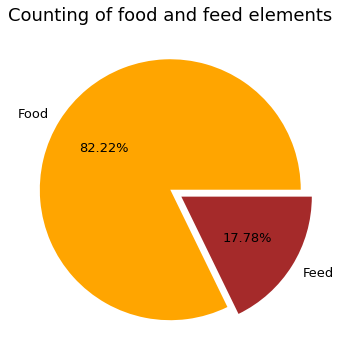

In [59]:
elements = df_prod["Element"].value_counts()

labels = elements.index
explode = [0, 0.1] 
colors = ['orange', 'brown']

plt.figure(figsize = (8,6))
plt.pie(elements, labels=labels, explode=explode, autopct='%1.2f%%', colors=colors, textprops={'fontsize': 13})

plt.title("Counting of food and feed elements", fontsize=18)
plt.show()

Come prevedibile, gli elementi che riguardano il cibo sono molti in più rispetto ai mangimi. 

Questo significa che nel tempo è stato prodotto molto più cibo che mangime?

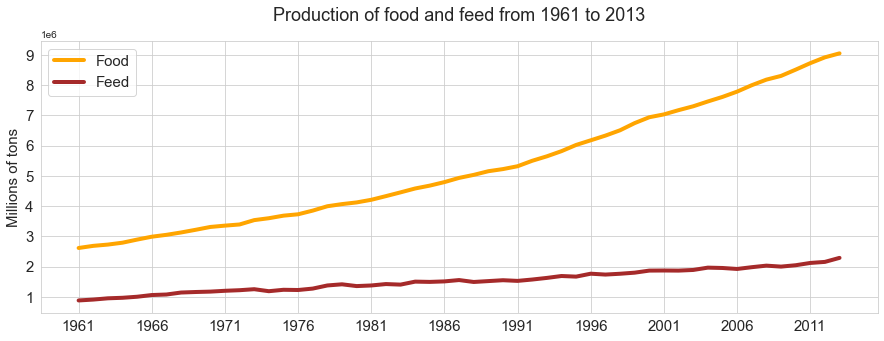

In [60]:
years_of_production = [str(n) for n in range(1961, 2013+1)]

# Raggruppo tutti gli elementi di cibi e mangimi e sommo i quantitativi prodotti ogni anno 
total_production = df_prod.groupby('Element')[years_of_production].sum()

sns.set_style('whitegrid')

plt.figure(figsize=(15,5))

sns.lineplot(data=total_production.loc['Food'], label='Food', linewidth=4, color='orange')
sns.lineplot(data=total_production.loc['Feed'], label='Feed', linewidth=4, color='brown')

plt.title('Production of food and feed from 1961 to 2013', size=18, pad=20)

plt.ylabel('Millions of tons', size=15)
plt.yticks(size=15)

plt.xticks(np.arange(0, len(years_of_production), 5), size=15)

plt.legend(prop={'size': 15})
plt.show()

Non solo è stato prodotto molto più cibo che mangime dal 1961 al 2013, ma anche il suo incremento di produzione è superiore. Infatti, in poco più di 50 anni la produzione di mangime è raddoppiata, mentre quella del cibo è più che triplicata!

Passo all'osservazione di qualche statistica compatta sui due estremi degli anni di produzione, osservando a quanto ammonta la produzione massima nel 1961 e nel 2013. Inoltre, voglio visualizzare quali sono i cibi, i mangimi e i paesi più frequenti nel dataframe.

In [61]:
aggregations = {
    'Max_prod_1961':pd.NamedAgg('1961', 'max'),
    'Max_prod_2013':pd.NamedAgg('2013', 'max'),
    'Most_frequent_product':pd.NamedAgg('Item', lambda n:n.mode()),
    }

max_prod = df_prod.groupby('Element').agg(**aggregations)


max_prod

,Max_prod_1961,Max_prod_2013,Most_frequent_product
Element,,,
Feed,112227,193043,Milk
Food,74071,489299,Milk


In [308]:
# [ ] Spiega la tabella e prepara la prossima cella di codice

In [62]:
# [ ] Trova un modo migliore per ricavare i numeri degli indici
indexes = df_prod.groupby(['Element', 'Item'])[['2013']].idxmax()

# arr_1961 = indexes['1961'].values.tolist()
arr_2013 = indexes['2013'].values.tolist()
# indx_1961 = [rows['1961'] for idx, rows in indexes.iterrows()]

# indx_2013 = [rows['2013'] for idx, rows in indexes.iterrows()]

# for idx, rows in indexes.iterrows():
#     print(rows['1961'])
#     print(rows['2013'])

# total_idx = indx_1961.extend(indx_2013)

arr_2013 = indexes['2013']

In [63]:
# [ ] Unisci a quella di prima e fai tutto in un passaggio
top_extremes = df_prod.loc[arr_2013, ['Area', 'Item', 'Element', '1961', '2013']]

numeric_increase = top_extremes['2013'] - top_extremes['1961']
perc_increase = round(numeric_increase/top_extremes['1961']*100, 2)

top_extremes['Production Increase (%)'] = perc_increase

top_extremes = top_extremes.drop(top_extremes[top_extremes['1961'] == 0].index)

top_extremes.sort_values(by='2013', ascending=False).head(10)

,Area,Item,Element,1961,2013,Production Increase (%)
2931,"China, mainland",Vegetables,Food,52968,489299,823.76
2870,"China, mainland","Vegetables, Other",Food,44728,426850,854.32
2919,"China, mainland",Cereals - Excluding Beer,Food,59256,209038,252.77
2918,"China, mainland",Cereals - Excluding Beer,Feed,17963,193043,974.67
2810,"China, mainland",Maize and products,Feed,13700,150000,994.89
2932,"China, mainland",Fruits - Excluding Wine,Food,2551,130129,5001.10
2807,"China, mainland",Rice,Food,26687,108321,305.89
6470,India,Milk,Food,17487,105807,505.06
2921,"China, mainland",Starchy Roots,Food,74071,95208,28.54
2805,"China, mainland",Wheat and products,Food,13615,87783,544.75


In [311]:
# [ ] Unisci a quella di prima e fai tutto in un passaggio
top_extremes = df_prod.loc[

        [16631, 3224, 3265, 3272], 
        ['Area', 'Item', 'Element', '1961', '2013']

        ].sort_values(by='2013', ascending=False).reset_index()

top_extremes['Ratio_1961_2013'] = round(top_extremes['2013']/top_extremes['1961'], 2)
top_extremes

,index,Area,Item,Element,1961,2013,Ratio_1961_2013
0,3272,China,Potatoes and products,Feed,1960,22165,11.31
1,3224,China,Sunflower seed,Feed,0,1240,inf
2,3265,China,Barley and products,Food,3902,208,0.05
3,16631,United Arab Emirates,Oilcrops,Food,0,105,inf


In [312]:
# [ ] Spiega la tabella ottenuta qui sopra e prepara la prossima mossa

In [313]:
# [ ] Questa è sia da sistamre che da aggiustare

# Top 3 produttori nel 2013
aggregations = {'Top produzione 2013 (1000 tonnellate)':pd.NamedAgg('2013', max)}

df_prod.groupby(['Area', 'Element']).agg(**aggregations).sort_values(by='Top produzione 2013 (1000 tonnellate)',
                                                                     ascending=False).head()

Top produzione 2013 (1000 tonnellate)
Area                     Element                                       
China                    Food                                    489299
                         Feed                                    193043
India                    Food                                    185884
United States of America Feed                                    140096
                         Food                                     81513

In [314]:
# [ ] Prepara la prossima mossa per la data vis o passare oltre e graficare dopo? In ogni caso va sfruttato plotly

In [315]:
country_data = px.data.gapminder()

map_fig = px.scatter_geo(
    country_data,
    locations = 'iso_alpha',
    projection = 'orthographic',
    color = 'continent',
    opacity = .8,
    hover_name = 'country',
    hover_data = ['lifeExp', 'pop', 'year']
    )

map_fig.show()

In [316]:
# Questo serve per visualizzare in html
# plotly.offline.plot(map_fig, filename= 'map_exp.html', auto_open=True)